In [ ]:
!pip install tensorflowjs

In [ ]:
import os
import gdown
import zipfile
import pathlib
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.15.0


In [ ]:
url = 'https://drive.google.com/uc?id=1p8Ka8QO9rLol_HHuTXdhuVze89CY1iXy'
output = 'garbagedataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1p8Ka8QO9rLol_HHuTXdhuVze89CY1iXy
To: /content/garbagedataset.zip
100%|██████████| 42.8M/42.8M [00:00<00:00, 53.0MB/s]


'garbagedataset.zip'

In [ ]:
local_zip = '/content/garbagedataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

PATH = '/content/garbagedataset'
PATH

'/content/garbagedataset'

In [ ]:
data_dir = pathlib.Path(PATH)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Total image from this datasets : {image_count}')

print(f'\nDistribution Image')
for i, label in enumerate(os.listdir(data_dir)):
  label_dir = os.path.join(data_dir, label)
  len_label_dir = len(os.listdir(label_dir))
  print(f'{i+1}. {label} : {len_label_dir}')

Total image from this datasets : 2527

Distribution Image
1. metal : 410
2. glass : 501
3. plastic : 482
4. paper : 594
5. cardboard : 403
6. trash : 137


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

np.random.seed(123)
seed = np.random.randint(0,100)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names_val = val_ds.class_names

print(f'List label Train data: \n{class_names}\n')
print(f'List label Validation data: \n{class_names_val}')

List label Train data: 
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

List label Validation data: 
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


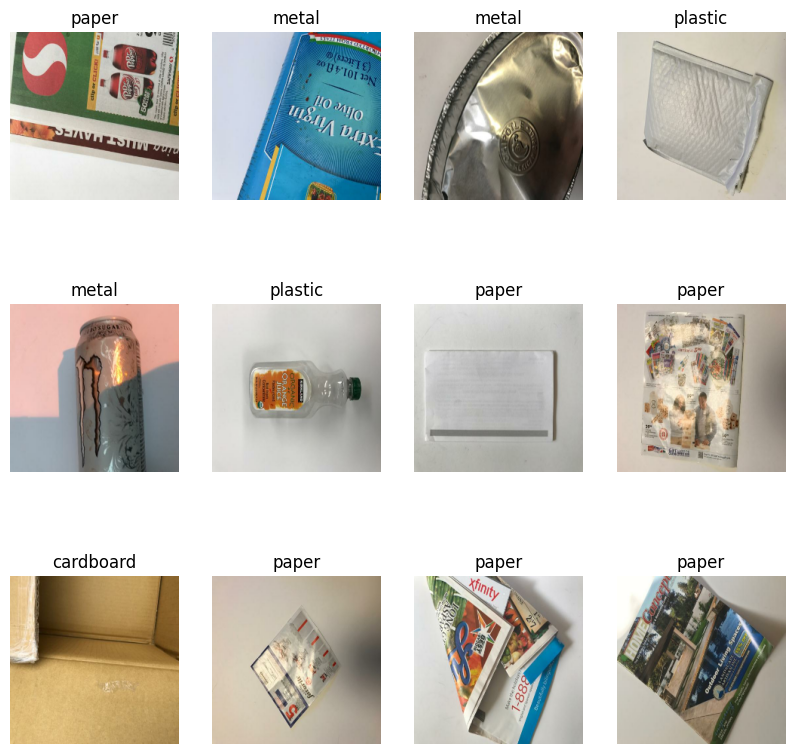

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 13
Number of test batches: 3


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2)],
  name="data_augmentation")

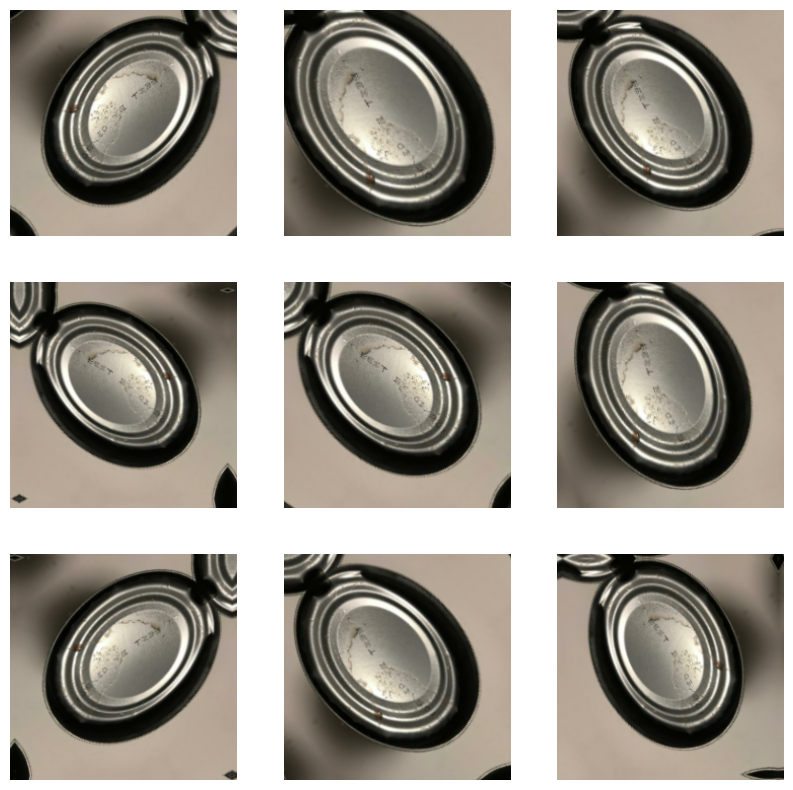

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.trainable = False
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))

In [ ]:
def model_builder():

  # Number Classes from data
  num_classes = len(class_names)

  # Create Model Sequential keras
  model = tf.keras.Sequential()

  # Add Custom Layer
  model.add(inputs)
  model.add(data_augmentation)
  model.add(normalization_layer)
  model.add(base_model)
  model.add(global_average_layer)

  # Add fully connected layer with dropout
  model.add(tf.keras.layers.Dense(units=512, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.2))

  # Prediction Layer
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="final_output"))

  base_learning_rate = 1e-3
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

  return model

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoint_model.h5",
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10,
                                                  mode ="max",
                                                  verbose=2,
                                                  restore_best_weights=True)

In [ ]:
model = model_builder()
print(f"Model : {model}")

Model : <keras.src.engine.sequential.Sequential object at 0x780a09166e30>


In [ ]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds,
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 1.0143 - accuracy: 0.6335
Epoch 1: val_accuracy improved from -inf to 0.77995, saving model to checkpoint_model.h5
64/64 [==============================] - 120s 2s/step - loss: 1.0143 - accuracy: 0.6335 - val_loss: 0.6263 - val_accuracy: 0.7800
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.6149 - accuracy: 0.7685
Epoch 2: val_accuracy improved from 0.77995 to 0.80196, saving model to checkpoint_model.h5
64/64 [==============================] - 111s 2s/step - loss: 0.6149 - accuracy: 0.7685 - val_loss: 0.5609 - val_accuracy: 0.8020
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.5260 - accuracy: 0.8116
Epoch 3: val_accuracy improved from 0.80196 to 0.81418, saving model to checkpoint_model.h5
64/64 [==============================] - 111s 2s/step - loss: 0.5260 - accuracy: 0.8116 - val_loss: 0.4853 - val_accuracy: 0.8142
Epoch 4/10
64/64 [==============================] - ETA

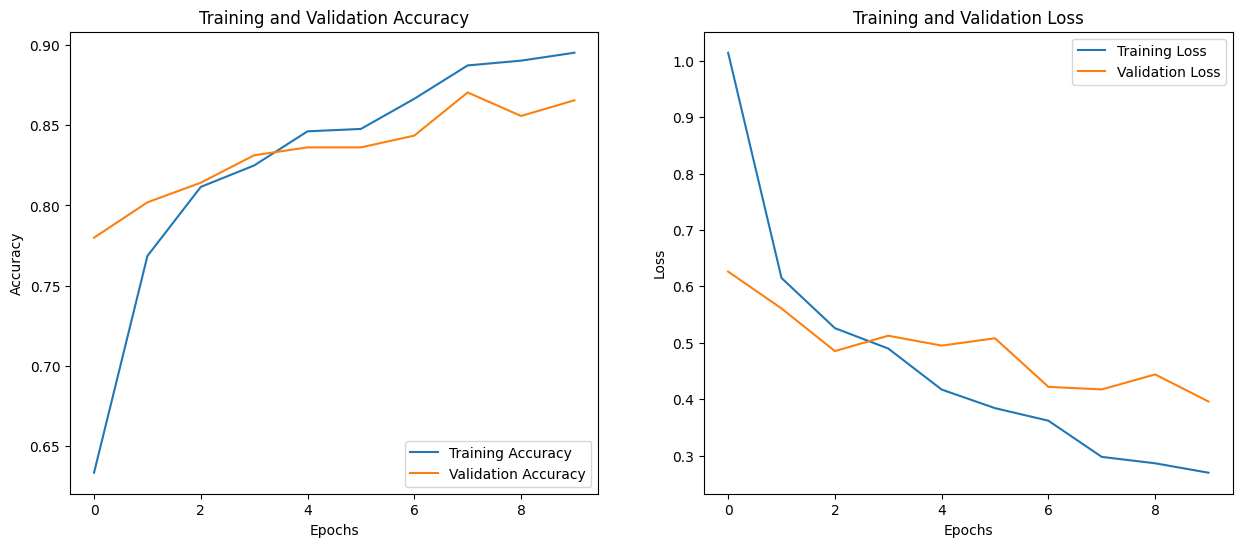

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
load_model = tf.keras.models.load_model('checkpoint_model.h5')
load_model.evaluate(x=test_dataset, return_dict=True)

3/3 [==============================] - 7s 2s/step - loss: 0.4989 - accuracy: 0.8333


{'loss': 0.498902827501297, 'accuracy': 0.8333333134651184}

Saving images (1).jpeg to images (1) (1).jpeg
1/1 [==============================] - 1s 1s/step
images (1) (1).jpeg
glass
[[3.0794598e-03 8.7673753e-01 7.2157055e-02 8.5410289e-04 4.5576941e-02
  1.5950573e-03]]
0.87673753


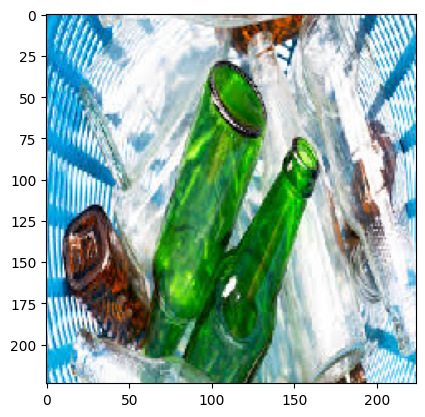

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size= IMG_SIZE + (3,))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = load_model.predict(images, batch_size=10)
  outclass = np.argmax(classes)

  print(fn)
  plt.imshow(img)
  for i, label in enumerate(class_names):
    if outclass == i:
      predic = classes[0][i]
      print(label)
      print(classes)
      print(predic)


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 512)               655872    
                                                      